# Simulator 1
Now we try to ensure that our simulation follows Poisson's Equastion

In [17]:
from fluid_sim import Fluid
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# Initialize Fluid without pipes and overrelaxation
fluid = Fluid(1, 64,64,1, 1.0)
fluid.initialize()

In [19]:
# Add Obstacle and simulate one step
fluid.set_obstacle(fluid.num_x // 2, fluid.num_y // 2, 1 / 30)
fluid.simulate(1/30, -9.81, 40)

In [20]:
# Apply gravity and solve incomressibility to obtain pressure
fluid.integrate(1/30, -9.81)
fluid.p = np.zeros((fluid.num_x, fluid.num_y))
fluid.solve_incomressibility(40, 1/30)

In [21]:
# save velocities and also center them in cells
v = fluid.v.copy()
u = fluid.u.copy()

new_u = u.copy()
new_v = v.copy()

for i in range(63):
    for j in range(63):
        new_u[i,j] = (u[i,j] + u[i+1, j]) / 2
        new_v[i,j] = (v[i,j] + v[i, j+1]) / 2

Now we have prepared our data and let's calculate The Laplaccian of P and RHS of Poisson's equation

In [24]:
# /delta^2 p = d^2p / dx^2 + d^2p / dy^2
laplassian_p = np.zeros((64,64))
dx = dy = fluid.h
for i in range(1,63):
    for j in range(1, 63):
        laplassian_p[i,j] = (fluid.p[i+1][j]  - 2*fluid.p[i][j] + fluid.p[i-1][j]) / dx**2 + (fluid.p[i, j+1]  - 2*fluid.p[i][j] + fluid.p[i, j-1] ) / dy ** 2
        # for now we don't care about borders

In [25]:
dt = 1/30 
g = np.zeros((64,64))  # RHS of Poisson's equation
for i in range(1,63):
    for j in range(1, 63):
        # g[i,j] = - (du_dx[i,j]**2 + dv_dy[i,j]**2 + 2*du_dy[i,j]*dv_dx[i,j])
        g[i, j] = fluid.density / dt * ((new_u[i+1][j]  -  new_u[i-1][j]) / (2*dx) + (new_v[i,j+1] - new_v[i, j-1]) / (2*dy))

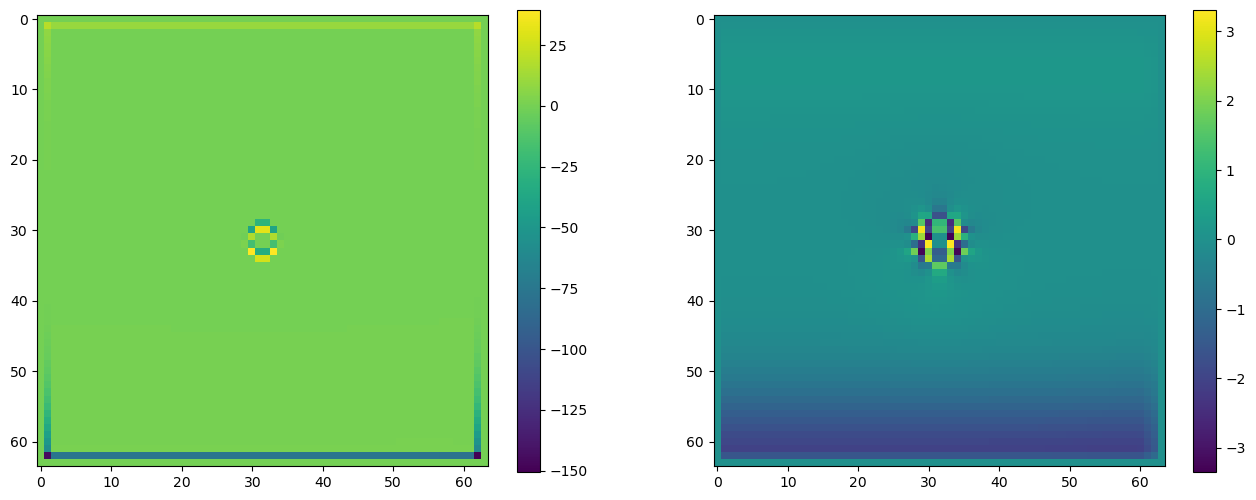

In [31]:
# Show our obtained figures
fig, (ax_p, ax_g) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
p_im = ax_p.imshow(np.rot90(laplassian_p))

g_im = ax_g.imshow(np.rot90(g))
fig.colorbar(p_im)
fig.colorbar(g_im)
plt.show()

Whoops! We have a probelem: LHS and RHS of Poisson's Equation are not equal. Maybe There is a problem with simulator, since it calculates Pressure in a strange way. Let's try another one with strict realization 

# Simulator 2 
in `fluid_sim2.py` we re-implement simulator from this [video](https://www.youtube.com/watch?v=63Ik8uZMxCQ)
It has two steps: calculating pressure and adjucting velocities

In [1]:
from fluid_sim2 import Fluid as Fluid2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
fl2 = Fluid2()

In [3]:
# we take on full iteration and one for only solving P
fl2.solve(0.001)
fl2.advect(0.001)
fl2.solve(0.001)

In [4]:
# as with previous simulator let's check Poison's Equastion
laplassian_p = np.zeros((64, 64))
dx = dy = fl2.h
for i in range(1, fl2.nx - 1):
    for j in range(1, fl2.ny - 1):
        laplassian_p[i, j] = (fl2.p[i+1,j] - 2*fl2.p[i,j] + fl2.p[i-1,j]) / dx**2 + (fl2.p[i, j+1] - 2*fl2.p[i,j] + fl2.p[i,j-1]) / dy**2

In [5]:
g = np.zeros((64,64))
for i in range(1, fl2.nx - 1):
    for j in range(1, fl2.ny - 1):
        g[i,j] = fl2.rho / 0.001 * ((fl2.u[i+1, j] - fl2.u[i-1,j]) / (2*dx) + (fl2.v[i,j+1] - fl2.v[i,j-1]) / (2*dy))

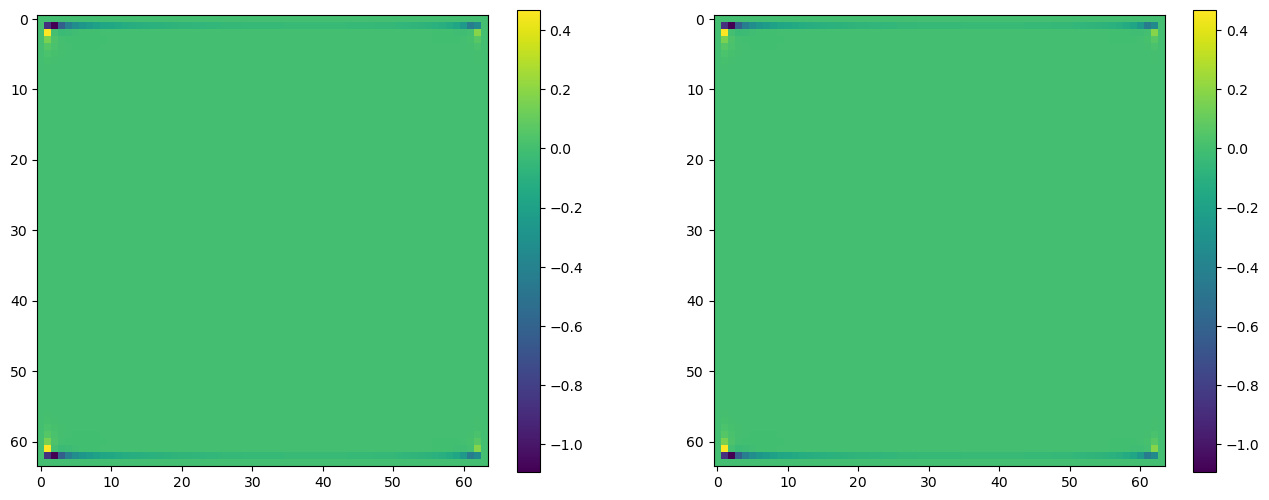

In [6]:
# Show our obtained figures
fig, (ax_p, ax_g) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
p_im = ax_p.imshow(np.rot90(laplassian_p))

g_im = ax_g.imshow(np.rot90(g))
fig.colorbar(p_im)
fig.colorbar(g_im)
plt.show()

It seems they are simmilar and we can use it to train our networks! Let's also show pressure and horizontal velocity

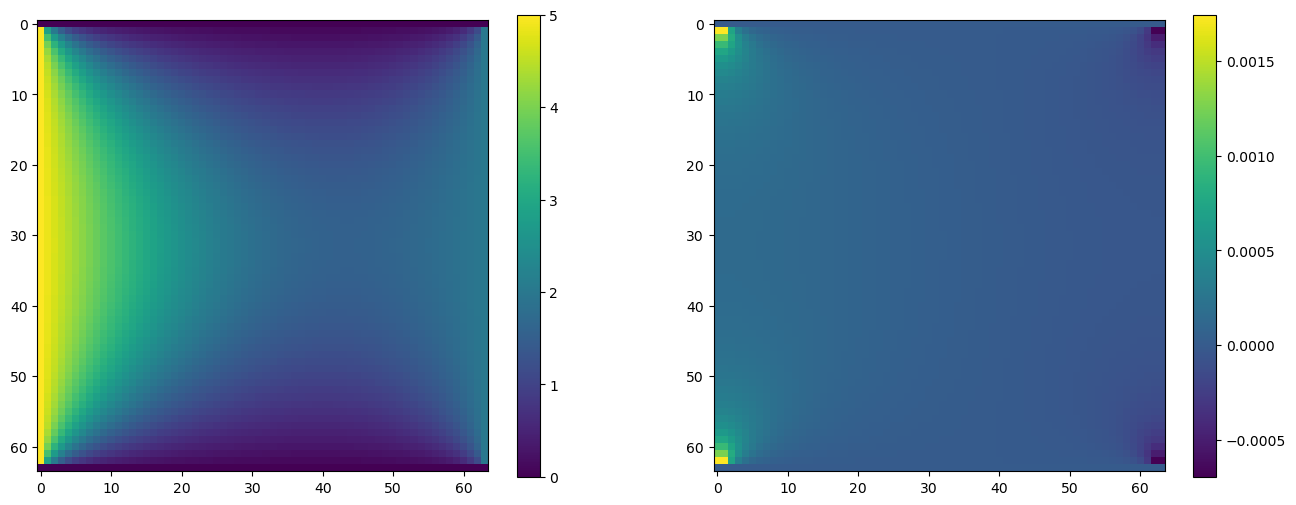

In [7]:
# Show our obtained figures
fig, (ax_p, ax_g) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
p_im = ax_p.imshow(np.rot90(fl2.p))

g_im = ax_g.imshow(np.rot90(fl2.u))
fig.colorbar(p_im)
fig.colorbar(g_im)
plt.show()

Looking Ok, but it's better to check it's work in animation after we obtain some data later (this simulator is quite slow)

# Checking dataset generation with Simulator 2
Now, let's look the sample generated by this simulator called like

`python .\fluid_sim2.py --dst old_sim.npz --fast --frames 1000 --dt 0.01`

`--fast` mode will use numpy vector operations, which increase perfomance 100 times! 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# %matplotlib inline

In [41]:
sample = np.load('old_sim.npz')

In [42]:
for key in sample.keys():
    print(key, sample[key].shape)

p (1001, 64, 64)
v (1001, 64, 64)
u (1001, 64, 64)


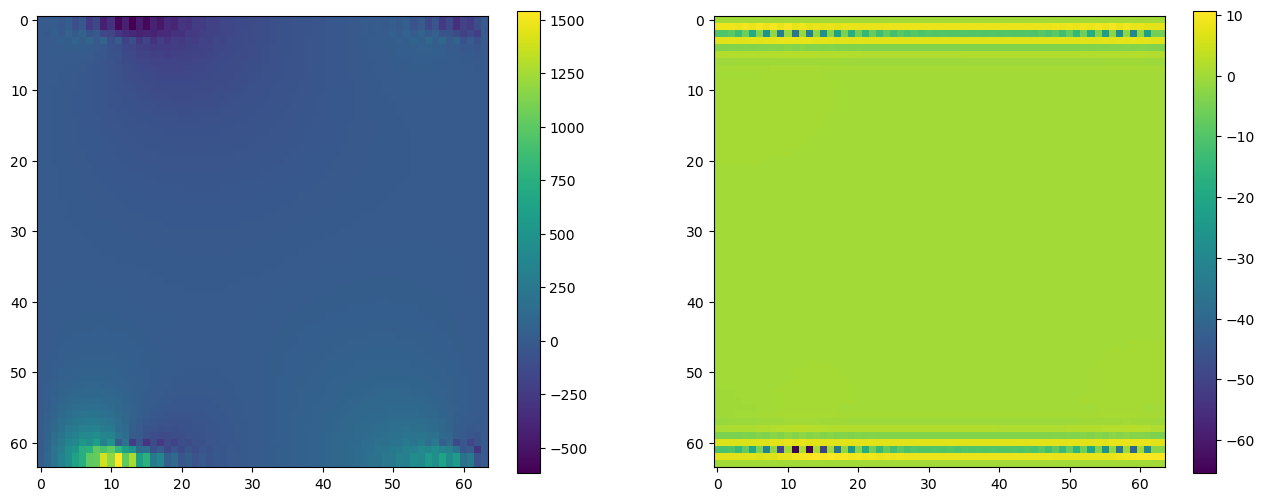

In [53]:
# Show our obtained figures
fig, (ax_p, ax_g) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
frame = 480
p_im = ax_p.imshow(np.rot90(sample['p'][frame]))

g_im = ax_g.imshow(np.rot90(sample['u'][frame-1]))
fig.colorbar(p_im)
fig.colorbar(g_im)
plt.show()

in some frame the simulation has started to collapse, which is very bad for our task 

# Simalator 3 
Now let's impement simulation from [numba](https://barbagroup.github.io/essential_skills_RRC/numba/4/), which differs from previous only in small addition calculating $b_{i,j}$ , additionaly substracting 
$\frac{d^2u}{dx^2} + 2\frac{du}{dy}\frac{dv}{dx}+ \frac{d^2v}{dy^2}$
we call it with

`python .\fluid_sim3.py --dst new_sim_10k.npz --fast --frames 10000 --dt 0.01`

In [57]:
sample = np.load('new_sim_10k.npz')

In [62]:
# Here we plot resulted animation, which do not collapse
fig, (ax_p, ax_v, ax_u) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax_p.axis('off')
ax_v.axis('off')
ax_u.axis('off')

class Scene:
    def __init__(self):
        self.frame = []
    
    def animate(self, i):
        while self.frame:
            self.frame[-1].remove()
            self.frame.pop()
            
        self.frame.append(ax_p.imshow(np.rot90(sample['p'][i*10])))
        self.frame.append(ax_u.imshow(np.rot90(sample['u'][i*10])))
        self.frame.append(ax_v.imshow(np.rot90(sample['v'][i*10])))
        return self.frame

scene=Scene()
ani = animation.FuncAnimation(fig, scene.animate, frames=sample['p'].shape[0] // 10, interval=int(1000 / 10), blit=True,                                 
                                  repeat=False)
plt.close()
HTML(ani.to_jshtml())
# plt.show()

Now our animation is not falling appart. Let's check our Poisson's Equastion

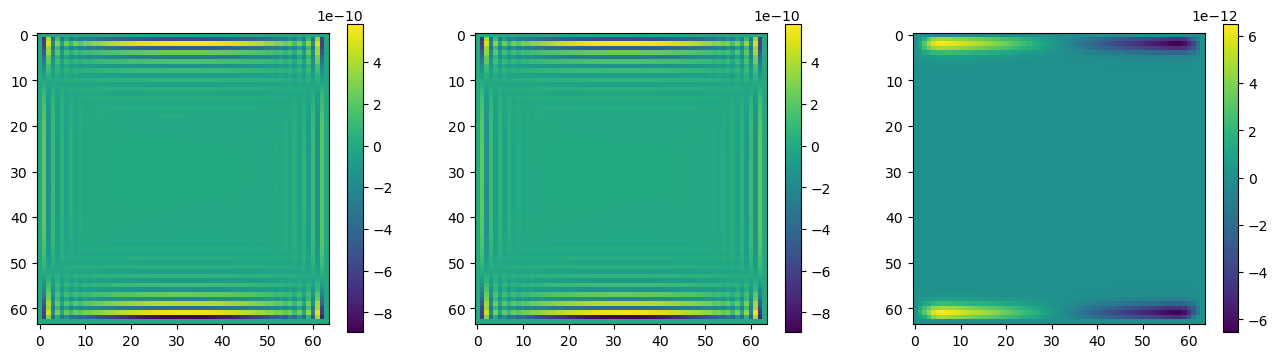

In [59]:
# as with previous simulator let's check Poison's Equastion with the same frame as before (2nd for p and 1st for u and v)
dx = dy = 1.
nx = ny = sample['p'].shape[1]
frame = 500
rho = 1.
dt = 0.01

p = sample['p'][frame]
u = sample['u'][frame-1]
v = sample['v'][frame-1]

# calculate in vector form
laplassian_p = np.zeros((64, 64))
laplassian_p[1:-1, 1:-1] = ((p[2:, 1:-1] - p[1:-1, 1:-1]*2 + p[:-2, 1:-1]) / dx**2 
                      + (p[1:-1, 2:] - p[1:-1, 1:-1]*2 + p[1:-1, :-2]) / dy**2)

# calculatign rho * du/dt
g = np.zeros((64,64)) 
g[1:-1, 1:-1] =  ((u[2:,1:-1] - u[:-2,1:-1]) / (2*dx) + (v[1:-1,2:] - v[1:-1,:-2])/ (2*dy)) * rho / dt


# calculating our new addition
g2 = np.zeros((64,64))
g2[1:-1, 1:-1] = (
    (u[2:, 1:-1] - u[:-2, 1:-1])**2 / (4*dx**2) 
     + (v[1:-1, 2:] - v[1:-1, :-2])**2 / (4*dy**2)
      +    (u[1:-1, 2:] - u[1:-1, :-2])*(v[2:, 1:-1] - v[:-2, 1:-1]) / (2*dx*dy)
) * (-rho)
        
# Show our obtained figures
fig, (ax_p, ax_g, ax_g2) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

p_im = ax_p.imshow(np.rot90(laplassian_p))
g_im = ax_g.imshow(np.rot90(g))
g2_im = ax_g2.imshow(np.rot90(g2))

fig.colorbar(p_im)
fig.colorbar(g_im)
fig.colorbar(g2_im)
plt.show()

Here we can see how small our addition is, but it allows our simulation to stay alive! Lets check that laplassian - g - g2 is almoust zero

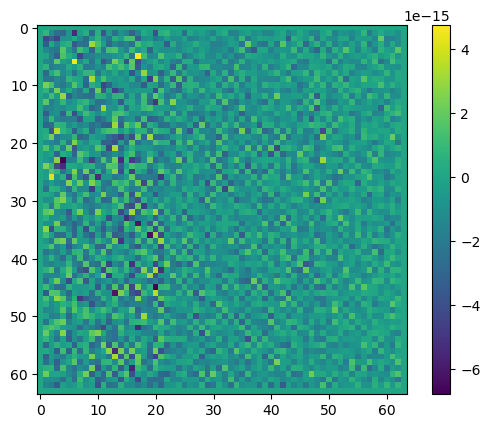

In [60]:
plt.imshow(np.rot90(laplassian_p - g - g2))
plt.colorbar()
plt.show()

Finally, our dateset generation script is working as it has to. So' we can generate more data and start building the neural netwrorks!

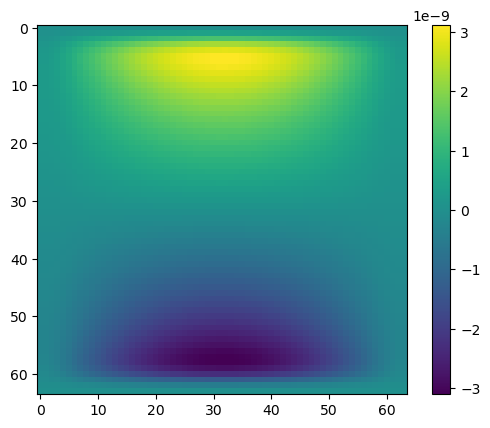

In [78]:
plt.imshow(np.rot90(v))
plt.colorbar()
plt.show()

In [65]:
p[:,1]

array([5.        , 4.95238095, 4.90476191, 4.85714286, 4.80952381,
       4.76190476, 4.71428572, 4.66666667, 4.61904762, 4.57142858,
       4.52380953, 4.47619048, 4.42857143, 4.38095239, 4.33333334,
       4.28571429, 4.23809524, 4.1904762 , 4.14285715, 4.0952381 ,
       4.04761906, 4.00000001, 3.95238096, 3.90476191, 3.85714287,
       3.80952382, 3.76190477, 3.71428572, 3.66666668, 3.61904763,
       3.57142858, 3.52380953, 3.47619049, 3.42857144, 3.38095239,
       3.33333334, 3.28571429, 3.23809525, 3.1904762 , 3.14285715,
       3.0952381 , 3.04761906, 3.00000001, 2.95238096, 2.90476191,
       2.85714286, 2.80952382, 2.76190477, 2.71428572, 2.66666667,
       2.61904762, 2.57142858, 2.52380953, 2.47619048, 2.42857143,
       2.38095238, 2.33333334, 2.28571429, 2.23809524, 2.19047619,
       2.14285714, 2.0952381 , 2.04761905, 2.        ])

In [66]:
import torch

In [67]:
a = torch.ones(2,2)

In [69]:
a - 0.5

tensor([[0.5000, 0.5000],
        [0.5000, 0.5000]])

In [70]:
(a - 0.5)**2

tensor([[0.2500, 0.2500],
        [0.2500, 0.2500]])

In [72]:
a[:,:1]

tensor([[1.],
        [1.]])

In [77]:
a.shape[-1]

2